
### Rubina Iman Kabir 


In [2]:
# Packages
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,auc,accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelBinarizer,OneHotEncoder
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import os
import cv2
import sys

In [3]:
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Convolution2D, MaxPooling2D, LSTM
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
import time, pickle
from keras.utils import *
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 1. Generative Models for Text

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/ was refrenced to complete this task.

##### (b) Load Data

In [18]:
os.chdir('/Users/rubinakabir/Documents/552/books')

In [19]:
# Open books
books = []
for book in os.listdir():
    if 'TPP' in book or 'TAM.txt' in book or 'MLOE' in book or 'OKEWFSMP'in book:
        with open(book,'r') as file:
            book = file.read().lower()
            books.append(book)
            
# Convert to ASCII Integers Representation
char_to_int={}
c = 0
books_to_int = []
chars = []
for book in books:
    char_level = list(book)
    for letter in char_level:
        if ord(letter) > 255:
            continue
            
        elif letter.isalpha():
            char_to_int[letter] = char_to_int.get(letter,c)
            books_to_int.append(char_to_int[letter])
            chars.append(letter)
            
        elif letter.isdigit():
            char_to_int[letter] = char_to_int.get(letter,c)
            books_to_int.append(char_to_int[letter])
            chars.append(letter)
            
        elif ' ' in letter:
            char_to_int[letter] = char_to_int.get(letter,c)
            books_to_int.append(char_to_int[letter])
            chars.append(letter)
            
        if char_to_int.get(letter) == c:
            c = c + 1

int_books = np.array(books_to_int)
raw_text = np.array(chars)

In [20]:
u_chars = sorted(list(set(list(chars)))) # chars
n_chars = len(chars)
n_vocab = len(u_chars)


##### (c) LSTM

##### Window Size = 99
##### Get input and output data

In [22]:
# Set up input and output data for LSTM
seq_length = 99
Xdata = []
Ydata = []
for i in range(0,n_chars - seq_length,1):
    # Get sequence of length 99 from text
    seq_in = int_books[i: i + seq_length]
    # Get output letter from text
    seq_out = int_books[i+seq_length]
    Xdata.append(seq_in)
    Ydata.append(seq_out)

n_patterns = len(Xdata)
print("Total Patterns: ", n_patterns)

Total Patterns:  1506821


In [23]:
# Set up data for LSTM
Xtrain = np.reshape(Xdata,(n_patterns,seq_length,1))
Xtrain = Xtrain / float(n_vocab)
Ytrain = np_utils.to_categorical(Ydata)
print('Input size:\t',Xtrain.shape)
print('Output size: \t',Ytrain.shape)

Input size:	 (1506821, 99, 1)
Output size: 	 (1506821, 47)


###### Output layer size = 47 which is the size of the one hot encode of characters present in text. 

###### Checkpointing to keep network weights to find best set of weights in terms of loss.

In [27]:
# LSTM NN
model = Sequential()
model.add(LSTM(256,input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(47,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

###### LSTM was trained used 7 epochs due to computational power.

In [25]:
history = model.fit(Xtrain,Ytrain,epochs = 7,batch_size = 128,callbacks = callbacks_list)


Epoch 1/7
1506821/1506821 [==============================] - 5885s 4ms/step - loss: 2.7682 - acc: 0.2060

Epoch 00001: loss improved from inf to 2.76822, saving model to weights-improvement-01-2.7682-bigger.hdf5
Epoch 2/7
1506821/1506821 [==============================] - 5914s 4ms/step - loss: 2.3914 - acc: 0.3125

Epoch 00002: loss improved from 2.76822 to 2.39135, saving model to weights-improvement-02-2.3914-bigger.hdf5
Epoch 3/7
1506821/1506821 [==============================] - 5940s 4ms/step - loss: 2.1767 - acc: 0.3810

Epoch 00003: loss improved from 2.39135 to 2.17671, saving model to weights-improvement-03-2.1767-bigger.hdf5
Epoch 4/7
1506821/1506821 [==============================] - 5948s 4ms/step - loss: 2.0515 - acc: 0.4182

Epoch 00004: loss improved from 2.17671 to 2.05147, saving model to weights-improvement-04-2.0515-bigger.hdf5
Epoch 5/7
1506821/1506821 [==============================] - 6006s 4ms/step - loss: 1.9710 - acc: 0.4411

Epoch 00005: loss improved from 2.

###### Attempt to mimic Russel's writings by using the network with the best weights

In [28]:
# Get epoch with best weights to predict
filename = 'weights-improvement-07-1.8702-bigger.hdf5'
model.load_weights(filename)
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [29]:
# Test LSTM
start = '''There are those who take mental phenomena naively just as they would physical phenomena This school of psychologists tends not to emphasize the object'''.lower().strip()
pattern=[]
for letter in list(start.lower().strip())[0:99]:
    pattern.append(char_to_int[letter])
int_to_char = dict([[v,k] for k,v in char_to_int.items()])

for i in range(1000):
    x = np.reshape(pattern, (1,len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in list(pattern)]
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
    start = start + result
print('Attempt at mimicing text: \n\n',start)


Attempt at mimicing text: 

 there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to emphasize the object the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular the rera simele and the earticular 

The model clearly has issues in mimicing Russel's style and thoughts. It is repeating the same text over and over again-- hence the LSTM is underfit. To improve the model, I could increase the number of epochs to a resonable amount, such as 150, and add more layers to the network.

## 2. (Deep) CNNs for Image Colorization

https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5 was refrenced to complete this task.

#### (b) Extract 'bird' class

In [3]:
os.chdir('/Users/rubinakabir/Documents/552/cifar-10-batches-py')

In [4]:
# bird is label = 2
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        all_data = pickle.load(fo, encoding='bytes')
        labels = np.array(all_data[b'labels'])
        bird_inds = (labels == 2)
        bird_labels = labels[bird_inds]
        bird_data = all_data[b'data'][bird_inds]
        bird_data = bird_data.reshape((len(bird_data),3,32,32)).transpose(0,2,3,1)
    return bird_data

# open file and normalize
train_birds = []
test_birds = []
for file in os.listdir():
    if '.html' in file or '.meta' in file or '.DS' in file:
        continue
    elif 'test' in file:
        test_birds.append(unpickle(file))
    else: 
        train_birds.append(unpickle(file))
data = np.concatenate(train_birds)
test = np.concatenate(test_birds)


##### (c) Select pixels randomly

In [5]:
P = []
for img in data:
    for channel in img:
        k = int(np.ceil(len(channel) *0.9))
        inds = random.sample(range(len(channel)),k)
        p = [channel[i] for i in inds]
        P.append(p)
P = np.concatenate(P)
print(P,'  pixels selected to train with K-means.')

4640000

##### (d) K-means

In [6]:
km = KMeans(n_clusters = 4).fit(P)
main_colors = km.cluster_centers_
#main_colors = np.array([[0,0,128],[230,25,75],[170,255,195],[255,255,255]])
print('Selected RGB Triplets:',main_colors)

array([[156.04399289, 154.77674543, 134.14320553],
       [108.16521916, 107.89887291,  82.2344489 ],
       [ 48.69392623,  49.57874561,  38.31498142],
       [205.69970895, 211.18054929, 210.81239156]])

In [7]:
output_data = []
cluster_label = []
for img in data:
    img_data = []
    for channel in img:
        channel_data = []
        for pixel in channel:
            dists = []
            for color in main_colors:
                d = np.sqrt(np.sum((pixel-color)**2))
                dists.append(d)
            min_ind = np.argmin(dists)
            cluster_label.append(min_ind)
            new_pixel = [main_colors[min_ind]]
            channel_data.append(new_pixel)
        channel_data = np.concatenate(channel_data)
        img_data.append([channel_data])
    img_data = np.concatenate(img_data)  
    output_data.append(img_data)
    
tr_art_data = np.array(output_data)
cluster_label = np.array(cluster_label)
Ytrain = np_utils.to_categorical(cluster_label,4)
Ytrain = Ytrain.reshape(5000,32*32*4)

val_art_data = []
val_label = []
for img in test:
    img_data = []
    for channel in img:
        channel_data = []
        for pixel in channel:
            dists = []
            for color in main_colors:
                d = np.sqrt(np.sum((pixel-color)**2))
                dists.append(d)
            min_ind = np.argmin(dists)
            val_label.append(min_ind)
            new_pixel = [main_colors[min_ind]]
            channel_data.append(new_pixel)
        channel_data = np.concatenate(channel_data)
        img_data.append([channel_data])
    img_data = np.concatenate(img_data)  
    val_art_data.append(img_data)

val_art_data = np.array(val_art_data)
val_label = np.array(val_label)
Yval = np_utils.to_categorical(val_label,4)
Yval = Yval.reshape(1000,32*32*4)

##### (e) Convert images to grayscale

In [8]:
# Training Data
input_data = []
for im in data:
    gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    input_data.append(gray)
    
Xtrain = np.array(input_data).reshape(5000,32,32,1)

# Testing Data
val_data = []
for im in test:
    gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    val_data.append(gray)

val_data = np.array(val_data).reshape(1000,32,32,1)

##### (f) Deep CNN

In [5]:
model = Sequential()
model.add(Convolution2D(32, (5, 5), strides=(1,1), input_shape=(32,32,1), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (5, 5),activation='relu', padding='same' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (5, 5), activation='relu', padding='same' ))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(512))
model.add(Dense(32*32*4,activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [15]:
history = model.fit(Xtrain, Ytrain, validation_data=(val_data,Yval),epochs=60, batch_size=32)   


Train on 5000 samples, validate on 1000 samples
Epoch 1/60
5000/5000 [==============================] - 48s 10ms/step - loss: 8590.8381 - acc: 0.0000e+00 - val_loss: 8473.1331 - val_acc: 0.0000e+00
Epoch 2/60
5000/5000 [==============================] - 50s 10ms/step - loss: 8470.5651 - acc: 0.0000e+00 - val_loss: 8472.2177 - val_acc: 0.0000e+00
Epoch 3/60
5000/5000 [==============================] - 48s 10ms/step - loss: 8470.4259 - acc: 0.0000e+00 - val_loss: 8472.4653 - val_acc: 0.0000e+00
Epoch 4/60
5000/5000 [==============================] - 46s 9ms/step - loss: 8470.2154 - acc: 0.0000e+00 - val_loss: 8471.3312 - val_acc: 0.0000e+00
Epoch 5/60
5000/5000 [==============================] - 48s 10ms/step - loss: 8470.5678 - acc: 0.0000e+00 - val_loss: 8471.7913 - val_acc: 0.0000e+00
Epoch 6/60
5000/5000 [==============================] - 53s 11ms/step - loss: 8469.9219 - acc: 0.0000e+00 - val_loss: 8471.3270 - val_acc: 0.0000e+00
Epoch 7/60
5000/5000 [==============================]

###### Accracy and loss on train and test data. 
###### Plots of model loss and accuracy

5000/5000 [==============================] - 9s 2ms/step



 Train loss: 8056.898596875
Train accuracy: 0.0008
1000/1000 [==============================] - 2s 2ms/step



 Test loss: 8145.78884375
Test accuracy: 0.001


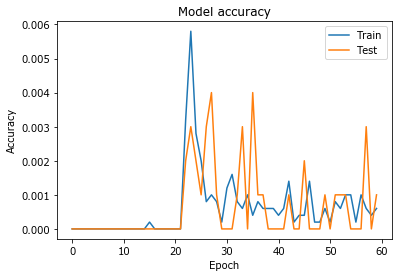

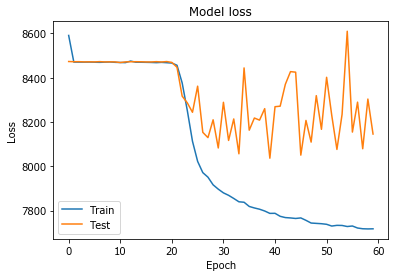

In [16]:
scores = model.evaluate(Xtrain, Ytrain, verbose=1)
print('\n\n\n Train loss:', scores[0])
print('Train accuracy:', scores[1])      

scores = model.evaluate(val_data, Yval, verbose=1)
print('\n\n\n Test loss:', scores[0])
print('Test accuracy:', scores[1])

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'])


The accuracy for both train and test data is all over the place. The training loss has a steep decline within the first couple epochs, then slowly decreases to a steady level as we progress through the epochs, until it reaches about 25 and exhibits another dip. It is hard to tell what the behavior of the validation loss with this plot is -- it seems that as we increase the number of epochs it may continue to have the same behavior for awhile.

Increasing the number of epochs should improve the model.

###### Comparison of artificially colored images from validation set

<Figure size 432x288 with 0 Axes>

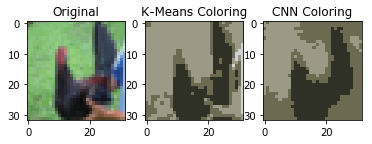

<Figure size 432x288 with 0 Axes>

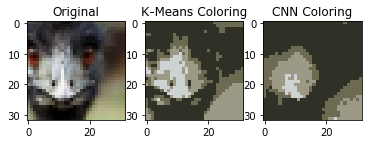

<Figure size 432x288 with 0 Axes>

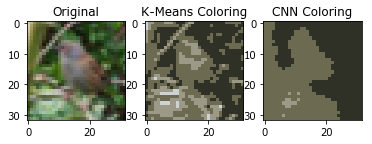

<Figure size 432x288 with 0 Axes>

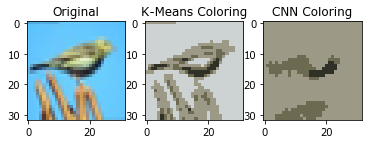

<Figure size 432x288 with 0 Axes>

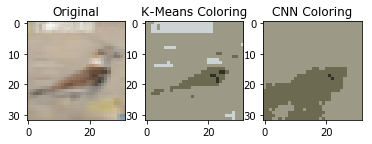

<Figure size 432x288 with 0 Axes>

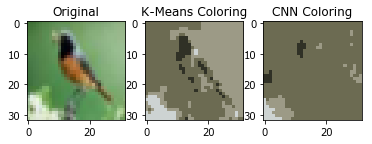

<Figure size 432x288 with 0 Axes>

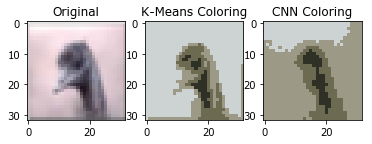

<Figure size 432x288 with 0 Axes>

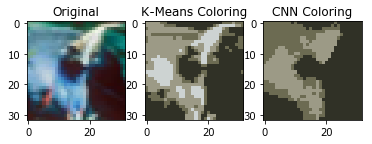

<Figure size 432x288 with 0 Axes>

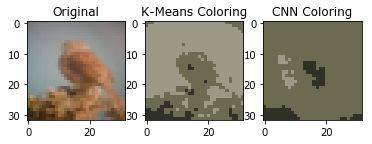

<Figure size 432x288 with 0 Axes>

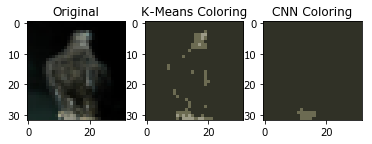

In [17]:
val_prediction = model.predict(val_data)
val_prediction = val_prediction.reshape(1000,32,32,4)
# Get coloring from predicted
coloring = []
for img in val_prediction[0:10]:
    colors = []
    for channel in img:
        for pixel in channel:
            max_prob_color = np.argmax(pixel)
            colors.append(main_colors[max_prob_color])
    colors = np.array(colors)
    coloring.append(colors.reshape(32,32,3))
    
# Plot first 10 images
for prediction, img in zip(range(10),val_art_data[0:10]):
    plt.figure()
    fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3)
    ax1.imshow(test[prediction])
    ax1.set_title('Original')
    ax2.imshow(np.uint8(img))
    ax2.set_title('K-Means Coloring')
    ax3.imshow(np.uint8(coloring[prediction]))
    ax3.set_title('CNN Coloring')
   

The K-Means model artificial coloring job does a good job in coloring the images. 

The CNN model does an okay job with some images as far as getting the location and shape of the bird in the images, where others it does a horrible job. To improve the model, I could use all possible colors and increase the number of epochs. 